# CS 475 HW 2 Programming

Name: Lisa Hou, Guangyan Li, Haochen Wei


In [65]:
# imports
import pandas as pd
import numpy as np
import random
from IPython.display import HTML, Math
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
             "latest.js?config=default'></script>"))

NOTEBOOK = 1
np.random.seed(1000)

# Section 1: Logistic Regression [10 points]



In this section, we are going to implement the logistic regression model with L2 regularization using gradient descent.


Your class must implement the following API (some functions has been implemented for you):

* `__init__(alpha, reg_lambda, epsilon, max_numIters, init_theta)`: the 
constructor, which takes in $\alpha$, $\lambda$, $\epsilon$, and max_numIters as arguments. init_theta is an optional parameter to set the initial value of theta.

* `fit(X,y)`: train the classifier from labeled data $(X,y)$. $X$ and $y$ are Pandas data frames.

* `predict(X)`: return a predicted class for each instance in the Pandas data frame $X$

* `predict_proba(X)`: return class probabilities for each instance in the Pandas data frame $X$

* `compute_cost(theta, X, y, reg_lambda)`:  computes the logistic regression objective function for the given values of $\theta$, $X$, $y$, and $\lambda$ (``lambda'' is a keyword in python, so we must call the regularization parameter something different). $X$ and $y$ are numpy matrices.

* `compute_gradient(theta, X, y, reg_lambda)`:  computes the $d$-dimensional gradient of the logistic regression objective for the given values of $\theta$, $X$, $y$, and reg_lambda=$\lambda$. $X$ and $y$ are numpy matrices.


* `sigmoid(z)`:  returns the sigmoid function of $z$


Note that these methods have already been defined correctly for you inLogisticRegression; be very careful not to change the API.


---





#### Training and Prediction

Your `fit` method should train the model via gradient descent, relying on the cost and gradient functions.  Instead of simply running gradient descent for a specific number of iterations, we will stop it after the solution has converged.  Stop the gradient descent procedure when $\theta$ stops changing between consecutive iterations.  You can detect this convergence when 
$\| {\theta}_\mathit{new} -  {\theta}_\mathit{old} \|_2 \leq \epsilon$, 
for some small $\epsilon$ (e.g, $\epsilon$ = 1E-4).  We implemented this convergence test as a dedicated function `has_converged`.  For safety, we will also set the maximum possible number of gradient descent iterations, max_numIters.  The values of $\lambda$, $\epsilon$,  max_numIters, and $\alpha$ (the gradient descent learning rate) are arguments to `LogisticRegression`'s constructor.  At the start of gradient descent, ${\theta}$ should be initialized to init_theta if specified or to random values with mean 0.

In [66]:
#TODO: complete following functions, including "fit", "predict" and "predict_proba"
class LogisticRegression:

    def __init__(self, alpha = 0.01, reg_lambda=0.01, epsilon=0.0001, max_numIters = 10000, init_theta = None):
        self.alpha = alpha
        self.reg_lambda = reg_lambda
        self.epsilon = epsilon
        self.max_numIters = max_numIters
        self.init_theta = init_theta
        self.theta = init_theta

    def compute_cost(self, theta, X, y, reg_lambda):
        n,d = X.shape
        y = y.reshape(n,1)
        # precursors
        theta = theta.reshape((d,1))
        y_hat = self.sigmoid(X.dot(theta)).reshape((n,1))
        # compute norms
        square = np.power(theta[1:],2)
        normTheta = np.sum(square)
        # compute cost
        cost = (-np.transpose(y).dot(np.log(y_hat)) - np.transpose(1-y).dot(np.log(1-y_hat))) + reg_lambda * normTheta         
        return cost[0][0]
    
        
    def has_converged(self, theta_old, theta_new, epsilon):
        return np.linalg.norm(theta_new - theta_old) <= epsilon    
    
    def compute_gradient(self, theta, X, y, reg_lambda):
        n,d = X.shape
        y = y.reshape(n,1)
        theta = theta.reshape((d,1))
        # compute gradient
        yhat = self.sigmoid(X.dot(theta))
        # sigma = 1/(1 + np.exp(-Z))
        gradient = (X.T).dot(yhat - y)
        # add regularization
        gradient[1:] = gradient[1:] + (reg_lambda * theta[1:])
        
        a, b = gradient.shape
        return gradient.reshape((a,))

    def fit(self, X, y):
        '''
        Trains the model
        Arguments:
            X is a n-by-d Pandas data frame
            y is an n-by-1 Pandas data frame
        Note:
            Don't assume that X contains the x_i0 = 1 constant feature.
            Standardization should be optionally done before fit() is called.
        '''
        numIters = 0
        X = np.append(np.ones((X.shape[0],1)), X, axis=1)  
        #print(X[0:3,:])
        n, d = X.shape
        y = y.to_numpy()
        
        if(self.init_theta.all() != None):
            theta_old = self.init_theta
        else:
            theta_old = pd.DataFrame(np.zeros((d, 1)))  
            
        while numIters <= self.max_numIters:
            gradient = self.compute_gradient(theta_old, X, y, self.reg_lambda)
            theta_new = theta_old - self.alpha * gradient
            if(self.has_converged(theta_old, theta_new, self.epsilon)):
                break
            theta_old = theta_new
            print("theta",theta_new)
            numIters+=1

        self.theta = theta_new
        return 
    
    def predict(self, X):
        '''
        Used the model to predict values for each instance in X
        Arguments:
            X is a n-by-d Pandas data frame
        Returns:
            an n-by-1 dimensional Pandas data frame of the predictions
        Note:
            Don't assume that X contains the x_i0 = 1 constant feature.
            Standardization should be optionally done before predict() is called.
            
        '''
        n, d = X.shape
        y_prob = self.predict_proba(X)
        y_pred = np.zeros((n, 1))
        for i in range(n):        
            if(y_prob[i] > 0.5):
                y_pred[i] = 1   
       
        return pd.DataFrame(y_pred)
    
    def predict_proba(self, X):
        '''
        Used the model to predict the class probability for each instance in X
        Arguments:
            X is a n-by-d Pandas data frame
        Returns:
            an n-by-1 Pandas data frame of the class probabilities
        Note:
            Don't assume that X contains the x_i0 = 1 constant feature.
            Standardization should be optionally done before predict_proba() is called.
        '''
        X = np.append(np.ones((X.shape[0],1)), X, axis=1)     
        n, d = X.shape
        theta = self.theta.reshape((d,1))
        y_prob = self.sigmoid(X.dot(theta))                
        
        return y_prob

   
    def sigmoid(self, Z):
        sigma = 1/(1 + np.exp(-Z))
        return sigma



## Test Logistic Regression 1

To test your logistic regression implementation, run `test_logreg1`.  This script trains a logistic regression model using your implementation and then uses it to predict whether or not a student will be admitted to a school based on their scores on two exams.  In the plot, the colors of the points indicate their true class label and the background color indicates the predicted class label.  If your implementation is correct, the decision boundary should closely match the true class labels of the points, with only a few errors, as per  below:

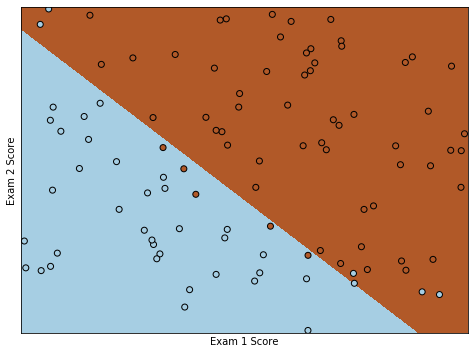

[[0. ]
 [0. ]
 [0. ]
 [0.5]
 [0.5]
 [0. ]
 [0.5]
 [0.5]
 [0.5]
 [0.5]]
Theta temp:  (2,)
TEMP:  54.86376158826352
theta [0.1        0.28122914 0.25098615]
theta [0.17577876 0.49518792 0.4422502 ]
theta [0.23574197 0.66395892 0.59329595]
theta [0.28544009 0.80240986 0.71733526]
theta [0.32814807 0.91961528 0.82247544]
theta [0.36583461 1.02123472 0.91378628]
theta [0.39974025 1.11096471 0.99457904]
theta [0.43068566 1.1913327  1.06711312]
theta [0.45923814 1.26413711 1.13299076]
theta [0.48580516 1.33070139 1.19338616]
theta [0.5106893  1.39202732 1.2491842 ]
theta [0.53412174 1.44889135 1.30106777]
theta [0.55628364 1.50190757 1.34957474]
theta [0.57732001 1.55157007 1.39513632]
theta [0.59734916 1.59828234 1.43810361]
theta [0.61646924 1.64237825 1.47876635]
theta [0.63476283 1.68413715 1.51736656]
theta [0.65230032 1.72379521 1.55410855]
theta [0.66914235 1.76155388 1.58916647]
theta [0.68534172 1.79758639 1.62269006]
theta [0.70094475 1.8320428  1.65480903]
theta [0.71599243 1.86505

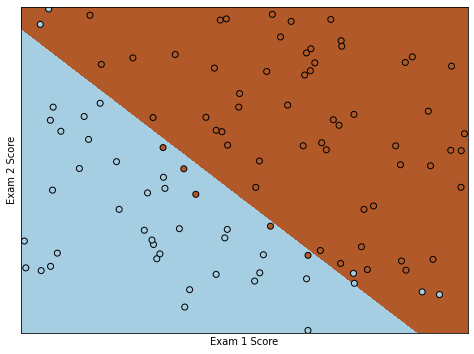

In [67]:
# Test script for training a logistic regressiom model
#
# You should download the hw2.csv first and load the hw2.csv file in the below_logreg1
#
# This code should run successfully without changes if your implementation is correct
#
from numpy import loadtxt, ones, zeros, where
import numpy as np
from pylab import plot,legend,show,where,scatter,xlabel, ylabel,linspace,contour,title
import matplotlib.pyplot as plt

def test_logreg1():
    # load the data
    filepath = "./hw2.csv" ## TODO: Load the hw2.csv file here!!!!
    df = pd.read_csv(filepath, header=None)

    X = df[df.columns[0:2]]
    y = df[df.columns[2]]

    n,d = X.shape
  
    # # Standardize features
    from sklearn.preprocessing import StandardScaler
    standardizer = StandardScaler()
    Xstandardized = pd.DataFrame(standardizer.fit_transform(X))  # compute mean and stdev on training set for standardization
    
    # train logistic regression
    init_theta = np.zeros(d+1,)
    logregModel = LogisticRegression(reg_lambda = 0.1, init_theta = init_theta)

    # Test compute_cost() function
    X_temp = np.asmatrix(X.to_numpy())[:10]
    y_temp = np.asmatrix(y.to_numpy()).reshape((X.shape[0],1))[:10]/2
    print(y_temp)
    theta_temp = np.array([0.25,-0.5])
    print("Theta temp: ",theta_temp.shape)
    print("TEMP: ",float(logregModel.compute_cost(theta_temp, X_temp, y_temp, 0.01)))
    logregModel.fit(Xstandardized, y)
    
    correct_weights = np.array([[1.519,3.522,3.273]])

    if np.linalg.norm(np.around(logregModel.theta, decimals=3) - correct_weights) < 0.001:
      print("Correct Weights: Your implementation is correct")
    else:
      print("Incorrect Weights: Please check your implementation")

    # Plot the decision boundary
    h = .02  # step size in the mesh
    x_min = X[X.columns[0]].min() - .5
    x_max = X[X.columns[0]].max() + .5
    y_min = X[X.columns[1]].min() - .5
    y_max = X[X.columns[1]].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    allPoints = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    allPoints = pd.DataFrame(standardizer.transform(allPoints))
    print(allPoints.shape)
    Z = logregModel.predict(allPoints)
    
    assert Z.shape == (12259096, 1), "The output shape of your predict() function is incorrect"

    Z = np.asmatrix(Z.to_numpy())

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
   
    # Plot the training points
    plt.scatter(X[X.columns[0]], X[X.columns[1]], c=y.ravel(), edgecolors='k', cmap=plt.cm.Paired)
    
    # Configure the plot display
    plt.xlabel('Exam 1 Score')
    plt.ylabel('Exam 2 Score')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    
    plt.show()

if NOTEBOOK == 1:
  test_logreg1() ### Comment out this line when submitting ###

# Section 2: Logistic Regression with Adagrad [10 points]

In this section, you'll implement logistic regression Adagrad with L2 regularization methods to see how it performs.

Start by duplicating your implementation of logistic regression from the previous exercise into the class `LogisticRegressionAdagrad`.  First, adjust your implementation to use stochastic  gradient  descent  instead  of  regular  gradient  descent.   The  training  should  run multiple loops over the entire training set, selecting each instance in turn.  The gradient is then computed for just that one instance, and the model parameters are updated accordingly based on that one gradient (not the average gradient). Once you have stochastic gradient descent tested and working, do the exploration on the Adagrad (learning source provided as follows).   

Adagrad adapts the learning rate to individual features, and changes it  over  time.   

$\theta_j = \theta_j - \frac{\alpha}{\sqrt{G_{t,j} + \zeta}} g_{t,j}$, where $G_{t, j} = \sum_{k=1}^t g_{k,j}^2$

Here $\zeta$ is a small positive value to avoid divide by zero error. $t$ represents an iteration, $g_{t,j}$ represents parameter $j$ at iteration $t$.

Several selected source for Adagrad: 

https://medium.com/konvergen/an-introduction-to-adagrad-f130ae871827

https://machinelearningmastery.com/gradient-descent-with-adagrad-from-scratch/

Modify  the  gradient  computation  to  use  Adagrad  instead  of  the  constant learning rate `alpha`, allowing it to adapt the learning rate for each feature. Test your implementation thoroughly.

**Note:** `computeCost` and `computeGradient` for Adagrad should be the same as the first section 1. Do not shuffle the training data. 

In [68]:
#TODO: complete the following functions, including "fit", "predict" and "predict_proba"
class LogisticRegressionAdagrad:

    def __init__(self, alpha = 0.01, reg_lambda=0.01, epsilon=0.0001, max_numIters = 20000, init_theta = None):
        self.alpha = alpha
        self.reg_lambda = reg_lambda
        self.epsilon = epsilon
        self.max_numIters = max_numIters
        self.init_theta = init_theta


    def compute_cost(self, theta, X, y, reg_lambda):
        n,d = X.shape
        y = y.reshape(n,1)
        # precursors
        theta = theta.reshape((d,1))
        y_hat = self.sigmoid(X.dot(theta)).reshape((n,1))
        # compute norms
        square = np.power(theta[1:],2)
        normTheta = np.sum(square)
        # compute cost
        cost = (-np.transpose(y).dot(np.log(y_hat)) - np.transpose(1-y).dot(np.log(1-y_hat))) + reg_lambda * normTheta 
        return cost[0][0]
        
    def has_converged(self, theta_old, theta_new, epsilon):
        return np.linalg.norm(theta_new - theta_old) <= epsilon
    
    def compute_gradient(self, theta, X, y, reg_lambda):
        n,d = X.shape
        y = y.reshape(n,1)
        theta = theta.reshape((d,1))
        # compute gradient
        yhat = self.sigmoid(X.dot(theta))
        # sigma = 1/(1 + np.exp(-Z))
        gradient = (X.T).dot(yhat - y)
        # add regularization
       
        gradient[1:] = gradient[1:] + (reg_lambda * theta[1:])
        a,b = gradient.shape
        return gradient.reshape((a,))


    def fit(self, X, y):
        '''
        Trains the model
        Arguments:
            X is a n-by-d Pandas data frame
            y is an n-by-1 Pandas data frame
        Note:
            Don't assume that X contains the x_i0 = 1 constant feature.
            Standardization should be optionally done before fit() is called.
        '''
        numIters = 0
        X = np.append(np.ones((X.shape[0],1)), X, axis=1)  
        n, d = X.shape
        y = y.to_numpy()
        
        if(self.init_theta.all() != None):
            theta_old = self.init_theta
            theta_new = theta_old
        else:
            theta_old = pd.DataFrame(np.zeros((d, 1)))  
            
        while numIters <= self.max_numIters:
            for i in range(n):
                gradient = self.compute_gradient(theta_new, np.array([X[i]]), np.array([y[i]]), self.reg_lambda)
                theta_new = theta_new - self.alpha * gradient
            if(self.has_converged(theta_old, theta_new, self.epsilon)):
                break
            theta_old = theta_new
            numIters+=1
        
        self.theta = theta_new
        print("fit complete",theta_new,numIters)
        return
    
    def predict(self, X):
        '''
        Used the model to predict values for each instance in X
        Arguments:
            X is a n-by-d Pandas data frame
        Returns:
            an n-by-1 dimensional Pandas data frame of the predictions
        Note:
            Don't assume that X contains the x_i0 = 1 constant feature.
            Standardization should be optionally done before predict() is called.
        ''' 
        n, d = X.shape
        y_prob = self.predict_proba(X)
        y_pred = np.zeros((n, 1))
        for i in range(n):        
            if(y_prob[i] > 0.5):
                y_pred[i] = 1   


        return pd.DataFrame(y_pred)

    def predict_proba(self, X):
        '''
        Used the model to predict the class probability for each instance in X
        Arguments:
            X is a n-by-d Pandas data frame
        Returns:
            an n-by-1 Pandas data frame of the class probabilities
        Note:
            Don't assume that X contains the x_i0 = 1 constant feature.
            Standardization should be optionally done before predict_proba() is called.
        '''
        X = np.append(np.ones((X.shape[0],1)), X, axis=1)     
        n, d = X.shape
        theta = self.theta.reshape((d,1))
        y_prob = self.sigmoid(X.dot(theta))                
        
        return y_prob


   
    def sigmoid(self, Z):
        sigma = 1/(1 + np.exp(-Z))
        return sigma

If your implementation of LogisticRegressionAdagrad is correct, the plot for test_logreg_2() should look like the following:

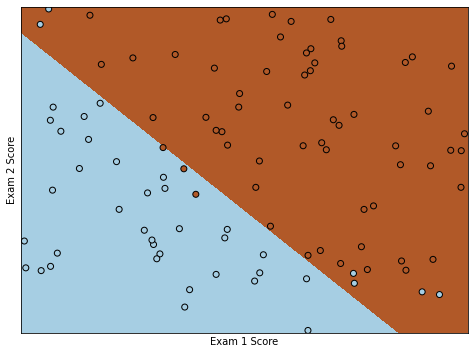

## Test Logistic Regression Adagrad

fit complete [0.5647491  0.97887231 0.88843084] 45


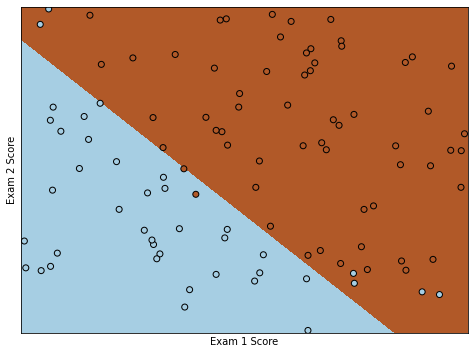

Test Failed: Your model contains incorrect weights. Please check your implementation


In [69]:
# Test script for training a logistic regressiom model
#
# You should download the hw2.csv first and load the hw2.csv file in the below_logreg1
#
# This code should run successfully without changes if your implementation is correct
#
from numpy import loadtxt, ones, zeros, where
import numpy as np
from pylab import plot,legend,show,where,scatter,xlabel, ylabel,linspace,contour,title
import matplotlib.pyplot as plt

def test_logreg_2():
    # load the data
    filepath = "./hw2.csv"  ## TODO: Load the hw2.csv file here!!!!
    df = pd.read_csv(filepath, header=None)

    X = df[df.columns[0:2]]
    y = df[df.columns[2]]
    n,d = X.shape

    # # Standardize features
    from sklearn.preprocessing import StandardScaler
    standardizer = StandardScaler()
    Xstandardized = pd.DataFrame(standardizer.fit_transform(X))  # compute mean and stdev on training set for standardization
    
    # train logistic regression
    init_theta = np.zeros(d+1,)
    logregModel = LogisticRegressionAdagrad(reg_lambda = 0.1,init_theta=init_theta)

    # Test nncomputeCost() function
    X_temp = np.asmatrix(X.to_numpy())[:10]
    y_temp = np.asmatrix(y.to_numpy()).reshape((X.shape[0],1))[:10]/2
    theta_temp = np.array([0.25,-0.5])

    
    # logregModel = LogisticRegression(reg_lambda=0.1)
    logregModel.fit(Xstandardized,y)
    
    # Plot the decision boundary
    h = .02  # step size in the mesh
    x_min = X[X.columns[0]].min() - .5
    x_max = X[X.columns[0]].max() + .5
    y_min = X[X.columns[1]].min() - .5
    y_max = X[X.columns[1]].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    allPoints = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    allPoints = pd.DataFrame(standardizer.transform(allPoints))
    Z = logregModel.predict(allPoints)
    Z = np.asmatrix(Z.to_numpy())

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.figure(1, figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot the training points
    plt.scatter(X[X.columns[0]], X[X.columns[1]], c=y.ravel(), edgecolors='k', cmap=plt.cm.Paired)
    
    # Configure the plot display
    plt.xlabel('Exam 1 Score')
    plt.ylabel('Exam 2 Score')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    
    plt.show()

    correct_weights = np.array([0.502,0.96 ,0.861])

    if np.linalg.norm(np.around(logregModel.theta,decimals=3) - correct_weights) < 0.01:
      print("Test Passed: Your model contains the correct weights")
    else:
      print("Test Failed: Your model contains incorrect weights. Please check your implementation")

if NOTEBOOK == 1:
  test_logreg_2() ### Comment out this line when submitting ###
